In [1]:
using Pkg
Pkg.activate("../")

using Revise
using ProbabilisticFSMs

 Activating environment at `~/GithubRepositories/ProbabilisticFSMs/Project.toml`
┌ Info: Precompiling ProbabilisticFSMs [c2ae6250-d0a1-11ea-0991-234599ce5244]
└ @ Base loading.jl:1260


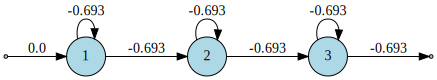

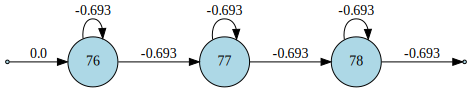

In [39]:
function makehmm(pdfidxs)
    fsm = FSM()
    prevstate = initstate(fsm)
    for pdfidx in pdfidxs
        state = addstate!(fsm, pdfindex = pdfidx)
        link!(fsm, state, state)
        link!(fsm, prevstate, state)
        prevstate = state
    end
    link!(fsm, prevstate, finalstate(fsm))
    fsm
    fsm |> weightnormalize
end

hmms = Dict()
for (i, l) in enumerate('a':'z')
    startidx = 3 * (i -1) + 1
    hmms[l] = makehmm([startidx, startidx + 1, startidx + 2])
end

display(hmms['a'])
display(hmms['z'])

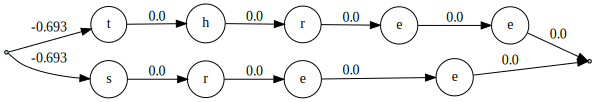

In [77]:
spelling = Dict(
    "zero"  => [("z", "e", "r", "o")],
    "one"   => [("o", "n", "e")],
    "two"   => [("t", "w", "o")],
    "three" => [("t", "h", "r", "e", "e"),
                ("s", "r", "e", "e")],  # French pronunciation 😁
    "four"  => [("f", "o", "u", "r")],
    "five"  => [("f", "i", "v", "e")],
    "six"   => [("s", "i", "x")],
    "seven" => [("s", "e", "v", "e", "n")],
    "eight" => [("e", "i", "g", "h", "t")],
    "nine"  => [("n", "i", "n", "e")]
)

function makepronunciation(pronunciation)
    fsm = FSM()
    prevstate = initstate(fsm)
    for letter in pronunciation
        state = addstate!(fsm, label = letter)
        link!(fsm, prevstate, state)
        prevstate = state
    end
    link!(fsm, prevstate, finalstate(fsm))
    fsm
end

lexicon = Dict()
for (word, pronunciations) in spelling
    lexicon[word] = union(makepronunciation.(pronunciations)...)
end

lexicon["three"] |> mi

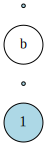

In [3]:
fsm = FSM()
addstate!(fsm, pdfindex = 1)
addstate!(fsm, label = "b")
fsm

In [111]:
emissionsmap = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3,
    "d" => 4
)

fsm = FSM()
s1 = addstate!(fsm, pdfindex = 1)
s2 = addstate!(fsm, pdfindex = 2)
s3 = addstate!(fsm, pdfindex = 3)

link!(fsm, initstate(fsm), s1)
link!(fsm, s1, s2)
link!(fsm, s2, s3)
link!(fsm, s3, finalstate(fsm))

1-element Array{Link,1}:
 Link{Float64}(State(finalstateid), State(3, pdfindex = 3), 0.0)

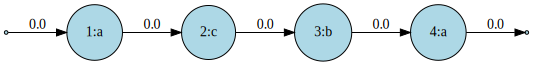

In [112]:
fsm1 = LinearFSM(["a", "c", "b", "a"], emissionsmap)

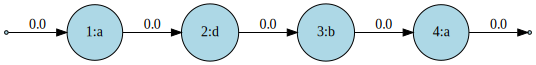

In [113]:
fsm2 = LinearFSM(["a", "d", "b", "a"], emissionsmap)

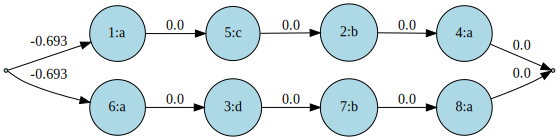

In [114]:
fsm = union(fsm1, fsm2)
fsm

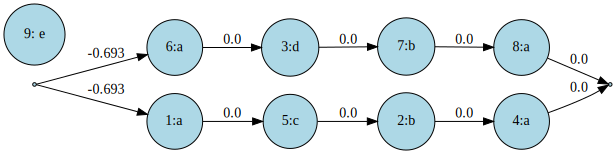

In [115]:
addstate!(fsm, pdfindex = 10, label = " e")
fsm

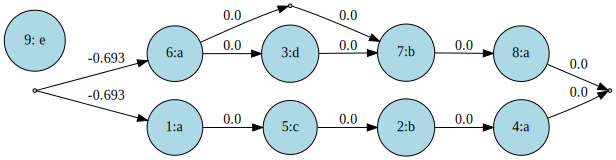

In [116]:
tmp = addstate!(fsm)
link!(fsm, fsm.states[6], tmp)
link!(fsm, tmp, fsm.states[7])
fsm

State(10)

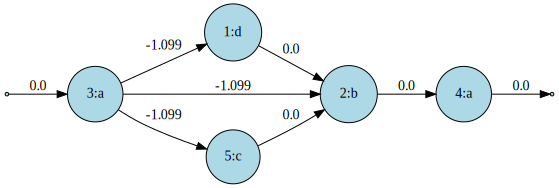

In [117]:
fsm = fsm |> minimize 

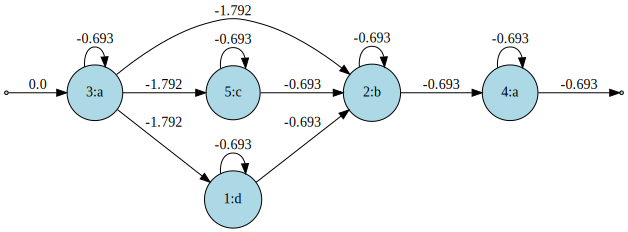

In [118]:
fsm = fsm |> addselfloop

In [102]:
D,N = 4, 10 # number of distributions times number of frames
v = randn(N, 1) .- 6 
llh = repeat(v', D)

4×10 Array{Float64,2}:
 -5.19144  -4.21072  -5.70837  -6.89491  …  -4.94642  -4.13722  -4.00131
 -5.19144  -4.21072  -5.70837  -6.89491     -4.94642  -4.13722  -4.00131
 -5.19144  -4.21072  -5.70837  -6.89491     -4.94642  -4.13722  -4.00131
 -5.19144  -4.21072  -5.70837  -6.89491     -4.94642  -4.13722  -4.00131

In [103]:
llh = zeros(4,5)

4×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [104]:
llh[:,1:2] .= [1, 0.5, 0, 0]
llh[:,3:4] .= [0.5, 1, 0.5, 0]
llh[:,5:5] .= [0, 0.5, 1, 0.5]
llh

4×5 Array{Float64,2}:
 1.0  1.0  0.5  0.5  0.0
 0.5  0.5  1.0  1.0  0.5
 0.0  0.0  0.5  0.5  1.0
 0.0  0.0  0.0  0.0  0.5

In [105]:
α = αrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 
α

[n = 1]  	3	3 = 1.000  
[n = 2]  	3	1 = -0.792  	2 = -0.292  	3 = 1.307  	5 = -0.792  
[n = 3]  	2	1 = -0.172  	2 = 3.145  	3 = 1.114  	4 = -0.485  	5 = 0.489  
[n = 4]  	2	1 = -0.074  	2 = 5.574  	3 = 0.921  	4 = 3.468  	5 = 1.116  
[n = 5]  	2	1 = 0.669  	2 = 6.395  	3 = 0.227  	4 = 4.996  	5 = 2.519  


In [106]:
β = βrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 
β

[n = 1]  	5	1 = 0.882  	2 = 0.676  	3 = 0.908  	4 = -0.773  	5 = 0.926  
[n = 2]  	5	1 = 0.601  	2 = 0.601  	3 = -0.019  	4 = -1.079  	5 = 0.715  
[n = 3]  	2	1 = -0.386  	2 = 0.088  	3 = -1.485  	4 = -0.886  	5 = -0.386  
[n = 4]  	2	2 = -0.693  	4 = -0.693  
[n = 5]  	4	4 = 0.000  


In [107]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
lnαβ

[n = 1]  	3	3 = 0.000  
[n = 2]  	3	1 = -2.099  	2 = -1.599  	3 = -0.620  	5 = -1.985  
[n = 3]  	2	1 = -3.889  	2 = -0.099  	3 = -3.702  	4 = -4.702  	5 = -3.228  
[n = 4]  	2	2 = -0.115  	4 = -2.221  
[n = 5]  	4	4 = 0.000  


In [108]:
path = viterbi(g, llh)

UndefVarError: UndefVarError: g not defined